# 生成地球运动数据

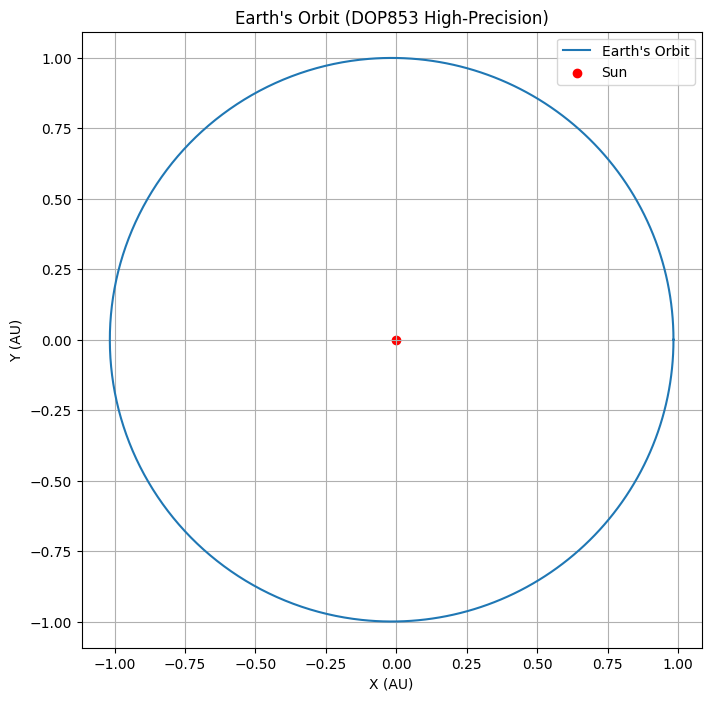

Sample coordinates and velocities (x, y, vx, vy) in AU and AU/day:
Point 1: (x=0.983290, y=0.000000, vx=0.000000, vy=0.017492)
Point 2: (x=0.983269, y=0.006395, vx=-0.000112, vy=0.017492)
Point 3: (x=0.983208, y=0.012791, vx=-0.000224, vy=0.017491)
Point 4: (x=0.983106, y=0.019185, vx=-0.000336, vy=0.017489)
Point 5: (x=0.982963, y=0.025579, vx=-0.000448, vy=0.017486)

Validation:
Energy (initial): -1.4795608787e-04 AU^2/day^2
Energy (final): -1.4795608787e-04 AU^2/day^2
Relative energy change: 4.7631119630e-15
Angular momentum (initial): 1.7199698045e-02 AU^2/day
Angular momentum (final): 1.7199698045e-02 AU^2/day
Relative angular momentum change: 2.2188713065e-15
Orbit closure error: 1.0470596582e-05 AU


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

# Constants (units: AU, days)
GM = 2.959122082855911e-4  # AU^3 / (M_sun * day^2)
a = 1.00000011  # Semi-major axis (AU)
e = 0.01671022  # Eccentricity
T = 365.25636  # Orbital period (days)
r0 = a * (1 - e)  # Perihelion distance (AU)
v0 = np.sqrt(GM * (1 + e) / (a * (1 - e)))  # Perihelion velocity (AU/day)

# Differential equations
def equations(t, state):
    x, x_dot, y, y_dot = state
    r = np.sqrt(x**2 + y**2)
    x_ddot = -GM * x / r**3
    y_ddot = -GM * y / r**3
    return [x_dot, x_ddot, y_dot, y_ddot]

# Energy and angular momentum
def total_energy(state):
    x = state[0]  # x
    x_dot = state[1]  # \dot{x}
    y = state[2]  # y
    y_dot = state[3]  # \dot{y}
    r = np.sqrt(x**2 + y**2)
    kinetic = 0.5 * (x_dot**2 + y_dot**2)
    potential = -GM / r
    return kinetic + potential

def angular_momentum(state):
    x = state[0]  # x
    x_dot = state[1]  # \dot{x}
    y = state[2]  # y
    y_dot = state[3]  # \dot{y}
    return x * y_dot - y * x_dot

# Initial conditions
state0 = [r0, 0.0, 0.0, v0]  # [x, \dot{x}, y, \dot{y}]
t_span = (0, T)  # One orbital period
t_eval = np.linspace(0, T, 1000)  # Output points

# High-precision integration with DOP853
solution = solve_ivp(
    equations,
    t_span,
    state0,
    method='DOP853',
    t_eval=t_eval,
    rtol=1e-13,
    atol=1e-13
)

# Extract results
t = solution.t
x = solution.y[0]
x_dot = solution.y[1]
y = solution.y[2]
y_dot = solution.y[3]

data = pd.DataFrame({
    'time': t,
    'x': x,
    'y': y,
    'x_dot': x_dot,
    'y_dot': y_dot  
})
# 保存到CSV文件
data.to_csv('xy_orbit.csv', index=False)


# Validation
energy = total_energy(solution.y)
ang_mom = angular_momentum(solution.y)
closure_error = np.sqrt((x[-1] - x[0])**2 + (y[-1] - y[0])**2)

# Plot orbit
plt.figure(figsize=(8, 8))
plt.plot(x, y, label="Earth's Orbit")
plt.scatter([0], [0], color='red', label="Sun")
plt.xlabel("X (AU)")
plt.ylabel("Y (AU)")
plt.title("Earth's Orbit (DOP853 High-Precision)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Output results
print("Sample coordinates and velocities (x, y, vx, vy) in AU and AU/day:")
for i in range(5):
    print(f"Point {i+1}: (x={x[i]:.6f}, y={y[i]:.6f}, vx={x_dot[i]:.6f}, vy={y_dot[i]:.6f})")

print("\nValidation:")
print(f"Energy (initial): {energy[0]:.10e} AU^2/day^2")
print(f"Energy (final): {energy[-1]:.10e} AU^2/day^2")
print(f"Relative energy change: {abs(energy[-1] - energy[0]) / abs(energy[0]):.10e}")
print(f"Angular momentum (initial): {ang_mom[0]:.10e} AU^2/day")
print(f"Angular momentum (final): {ang_mom[-1]:.10e} AU^2/day")
print(f"Relative angular momentum change: {abs(ang_mom[-1] - ang_mom[0]) / abs(ang_mom[0]):.10e}")
print(f"Orbit closure error: {closure_error:.10e} AU")
